# Predicting the noise level of noisy FashionMNIST images

The goal is to predict the noise level of a noisy image so it can be passed into a pretrained diffusion model.

It seems like a very simple task given that general denoising models exist: if a general denoising model gives you an accurate denoised image, and the difference between the noisy and denoised image gives you the noise, if the noise added to each pixel is independent and has th same variance, then the variance of this predicted noise should give an accurate estimate. Therefore, I suspect the accuracy of a noise prediction model is limited by the accuracy of a denoising model, which means the accuracy of a noise predictor won't be very good at high noise levels but very accurate at low noise levels. Although, I doubt the accuracy of the predicted noise level at high noise levels matters that much for a diffusion model.


I start out with adding noise to images the way DDPM does it (variance-preserving), but there is code to do it the way EDM (Karras et al.) does it (variance-exploding) as well.

## Imports

In [ ]:
import os
os.environ['OMP_NUM_THREADS']='1'

In [ ]:
#@title imports
import torch, random, datasets, fastcore.all as fc, numpy as np, matplotlib as mpl, matplotlib.pyplot as plt
import k_diffusion as K, torchvision.transforms as T
import torchvision.transforms.functional as TF,torch.nn.functional as F
from fastcore.foundation import L
from torch import nn
from datasets import load_dataset
from operator import itemgetter
from torcheval.metrics import MulticlassAccuracy

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *

In [ ]:
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

import logging
logging.disable(logging.WARNING)

set_seed(42)
if fc.defaults.cpus>8: fc.defaults.cpus=8

## Load dataset

Use 28x28 images, high batch size

In [ ]:
sz = 28
bs = 2048
input_channels = 1
sample_n = 64
num_workers = 8

In [ ]:
tfm = nn.Sequential(
    T.Resize(sz, interpolation=T.InterpolationMode.LANCZOS),
    T.CenterCrop(sz))

Load from torchvision

In [ ]:
xl,yl = 'image','label'
name = "fashion_mnist"
bs = 1024
dsd = load_dataset(name)
ds = dsd['train']
img = ds['image'][0]

  0%|          | 0/2 [00:00<?, ?it/s]

Get noise schedule (DDPM)

In [ ]:
betas = torch.linspace(0.0001, 0.02, 1000)
alphas = 1-betas
alpha_bar = torch.cumprod(alphas, dim=0)

In [ ]:
alpha_bar = torch.linspace(0.01, 1.0, 1000)

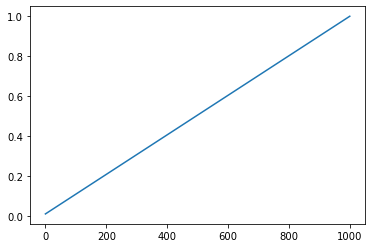

In [ ]:
plt.plot(alpha_bar);

In [ ]:
def get_x(x, i): return 

In [ ]:
xmean,xstd = 0.5, 0.5
n = len(alpha_bar)

def transformi(b):
    x = (TF.to_tensor(b[xl][0])-xmean)/xstd
    sig = alpha_bar[random.randrange(0, n)]
    return {xl: [x.lerp(torch.randn(x.shape), sig)], yl: [sig]}

In [ ]:
tdsd = dsd.with_transform(transformi)
tds = tdsd['train']

In [ ]:
b = tds[0]

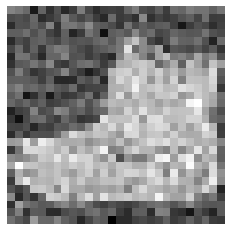

In [ ]:
show_image(b[xl]);

In [ ]:
dls = DataLoaders.from_dd(tdsd, bs, num_workers=fc.defaults.cpus)
dl = dls.train
xb,yb = next(iter(dl))

In [ ]:
titles = [f'{o.item():.2f}' for o in yb[:16]]

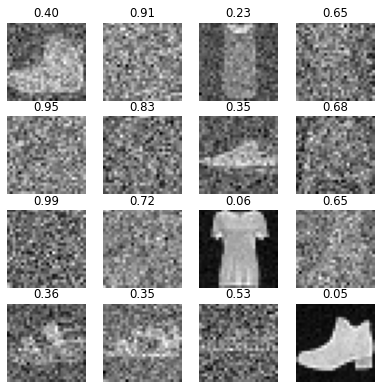

In [ ]:
mpl.rcParams['figure.dpi'] = 70
show_images(xb[:16], imsize=1.7, titles=titles)

In [ ]:
class f(nn.Module):
    def __init__(self):
        super().__init__()
        self.blah = nn.Linear(1,1)
    def forward(self,x): return 0.5*torch.ones((x.shape[0],)).cuda()

In [ ]:
metrics = MetricsCB()
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]

In [ ]:
lr = 1e-2
learn = TrainLearner(f(), dls, F.mse_loss, lr=lr, cbs=cbs)
learn.fit(1, train=False)

loss,epoch,train
0.083,0,eval


In [ ]:
import timm

In [ ]:
from functools import partial
from torch.optim import lr_scheduler
from torch import optim

In [ ]:
def flat_loss(x,y): return F.mse_loss(x.flatten(),y.flatten())

In [ ]:
epochs = 10
lr = 1e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
model = timm.create_model('resnet10t', in_chans=1, num_classes=1)
learn = TrainLearner(model, dls, flat_loss, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

loss,epoch,train
0.056,0,train
0.005,0,eval
0.005,1,train
0.014,1,eval
0.007,2,train
0.005,2,eval
0.004,3,train
0.001,3,eval
0.003,4,train
0.001,4,eval


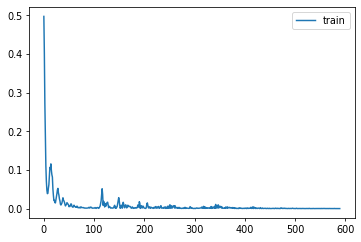

In [ ]:
learn.fit(epochs)